/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Accuracy: 0.9400
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       373
         1.0       0.93      0.99      0.96       727

    accuracy                           0.94      1100
   macro avg       0.95      0.92      0.93      1100
weighted avg       0.94      0.94      0.94      1100



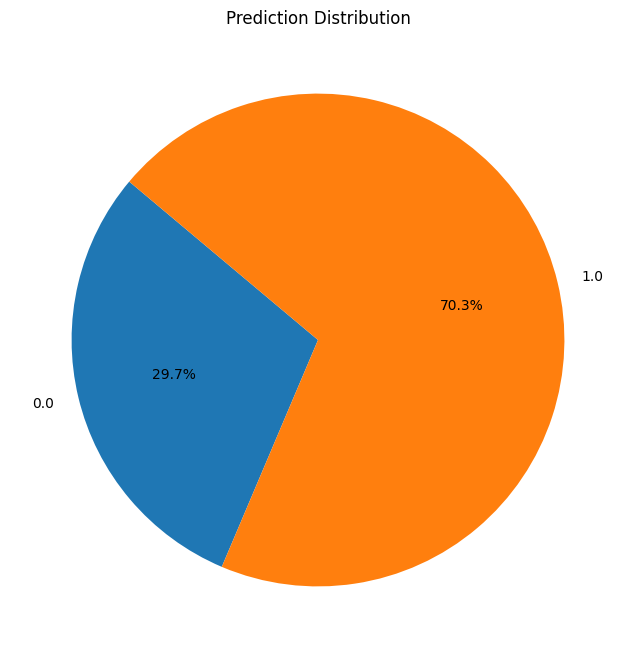

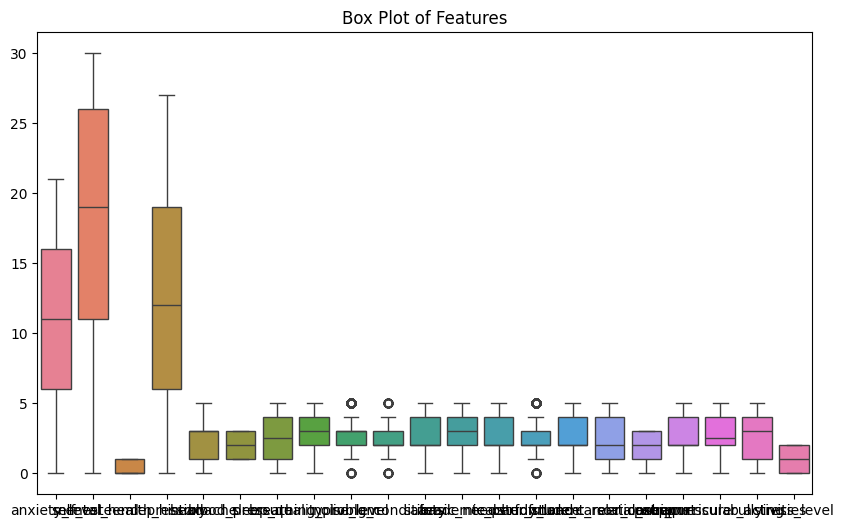

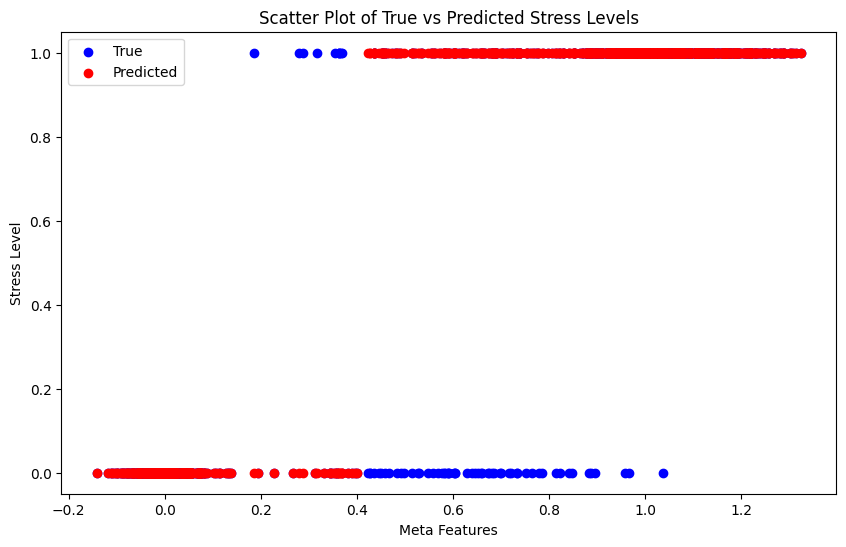

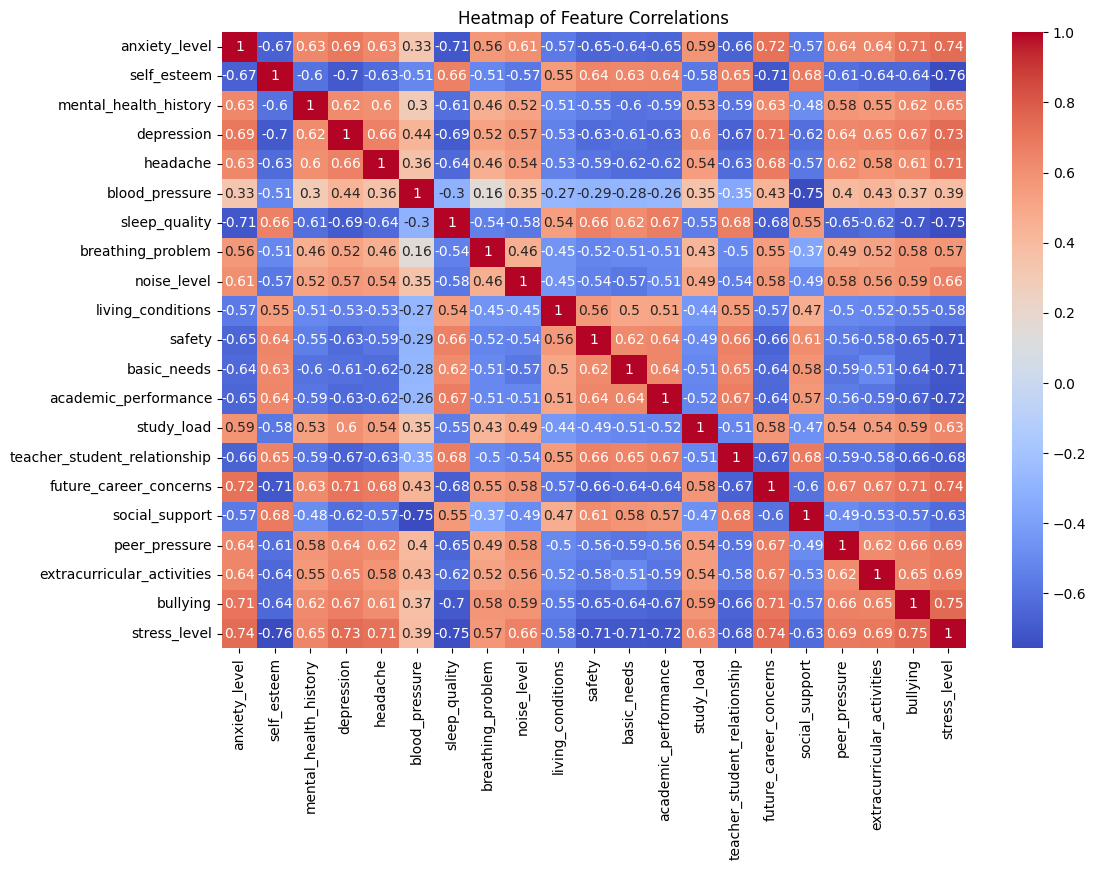

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


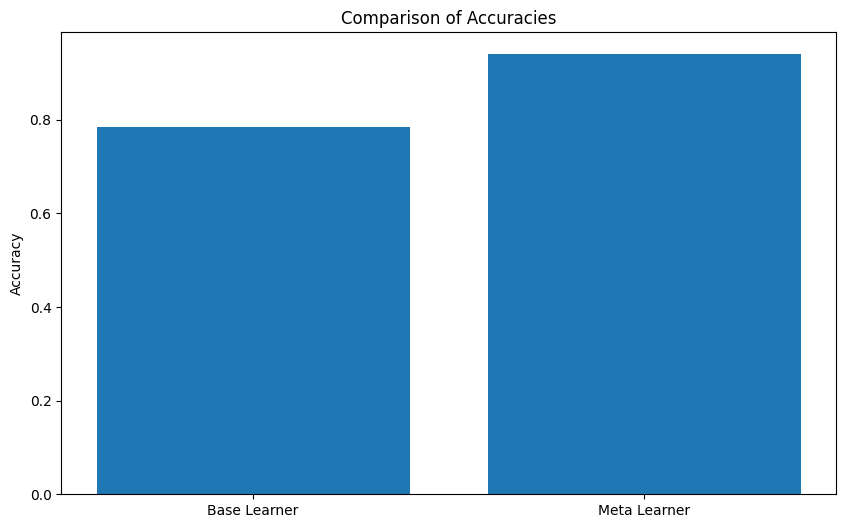

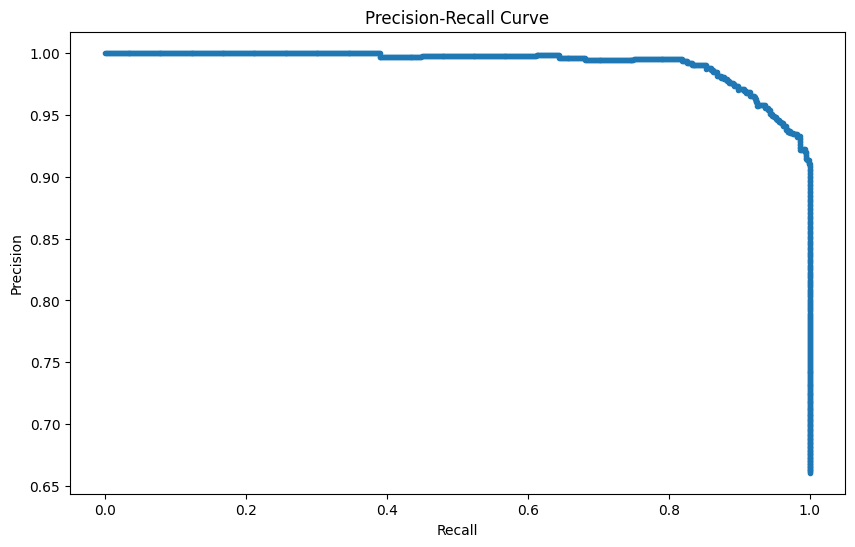

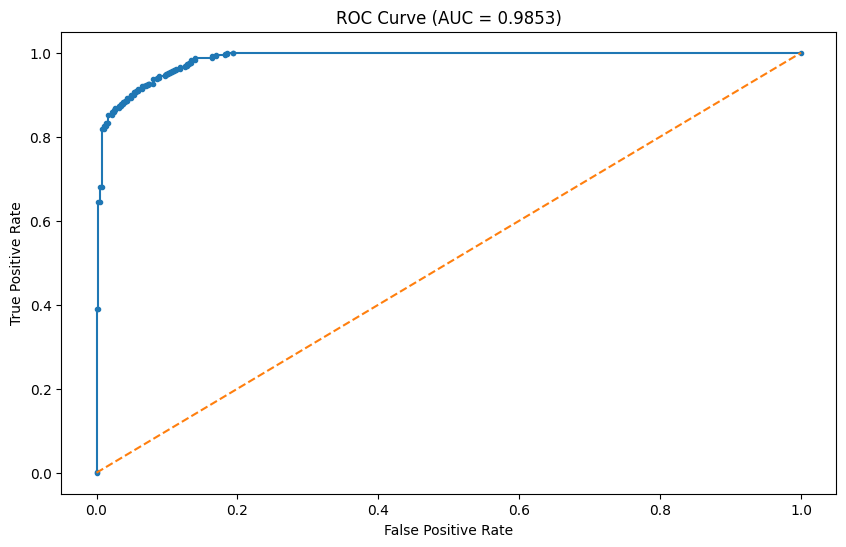

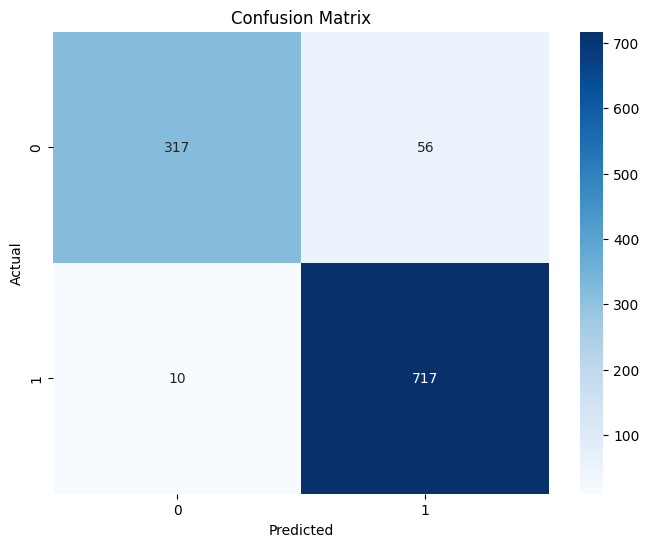

<ipython-input-1-871aa780100a>:159: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, shade=True)


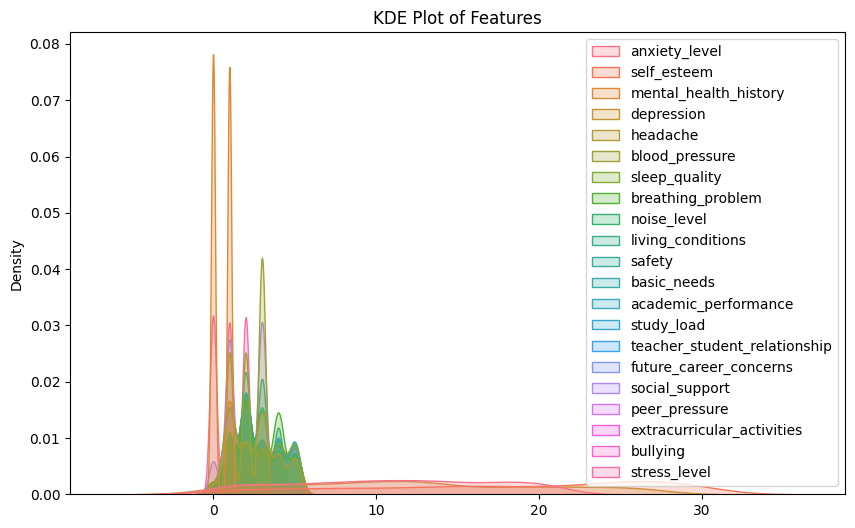

<Figure size 1000x600 with 0 Axes>

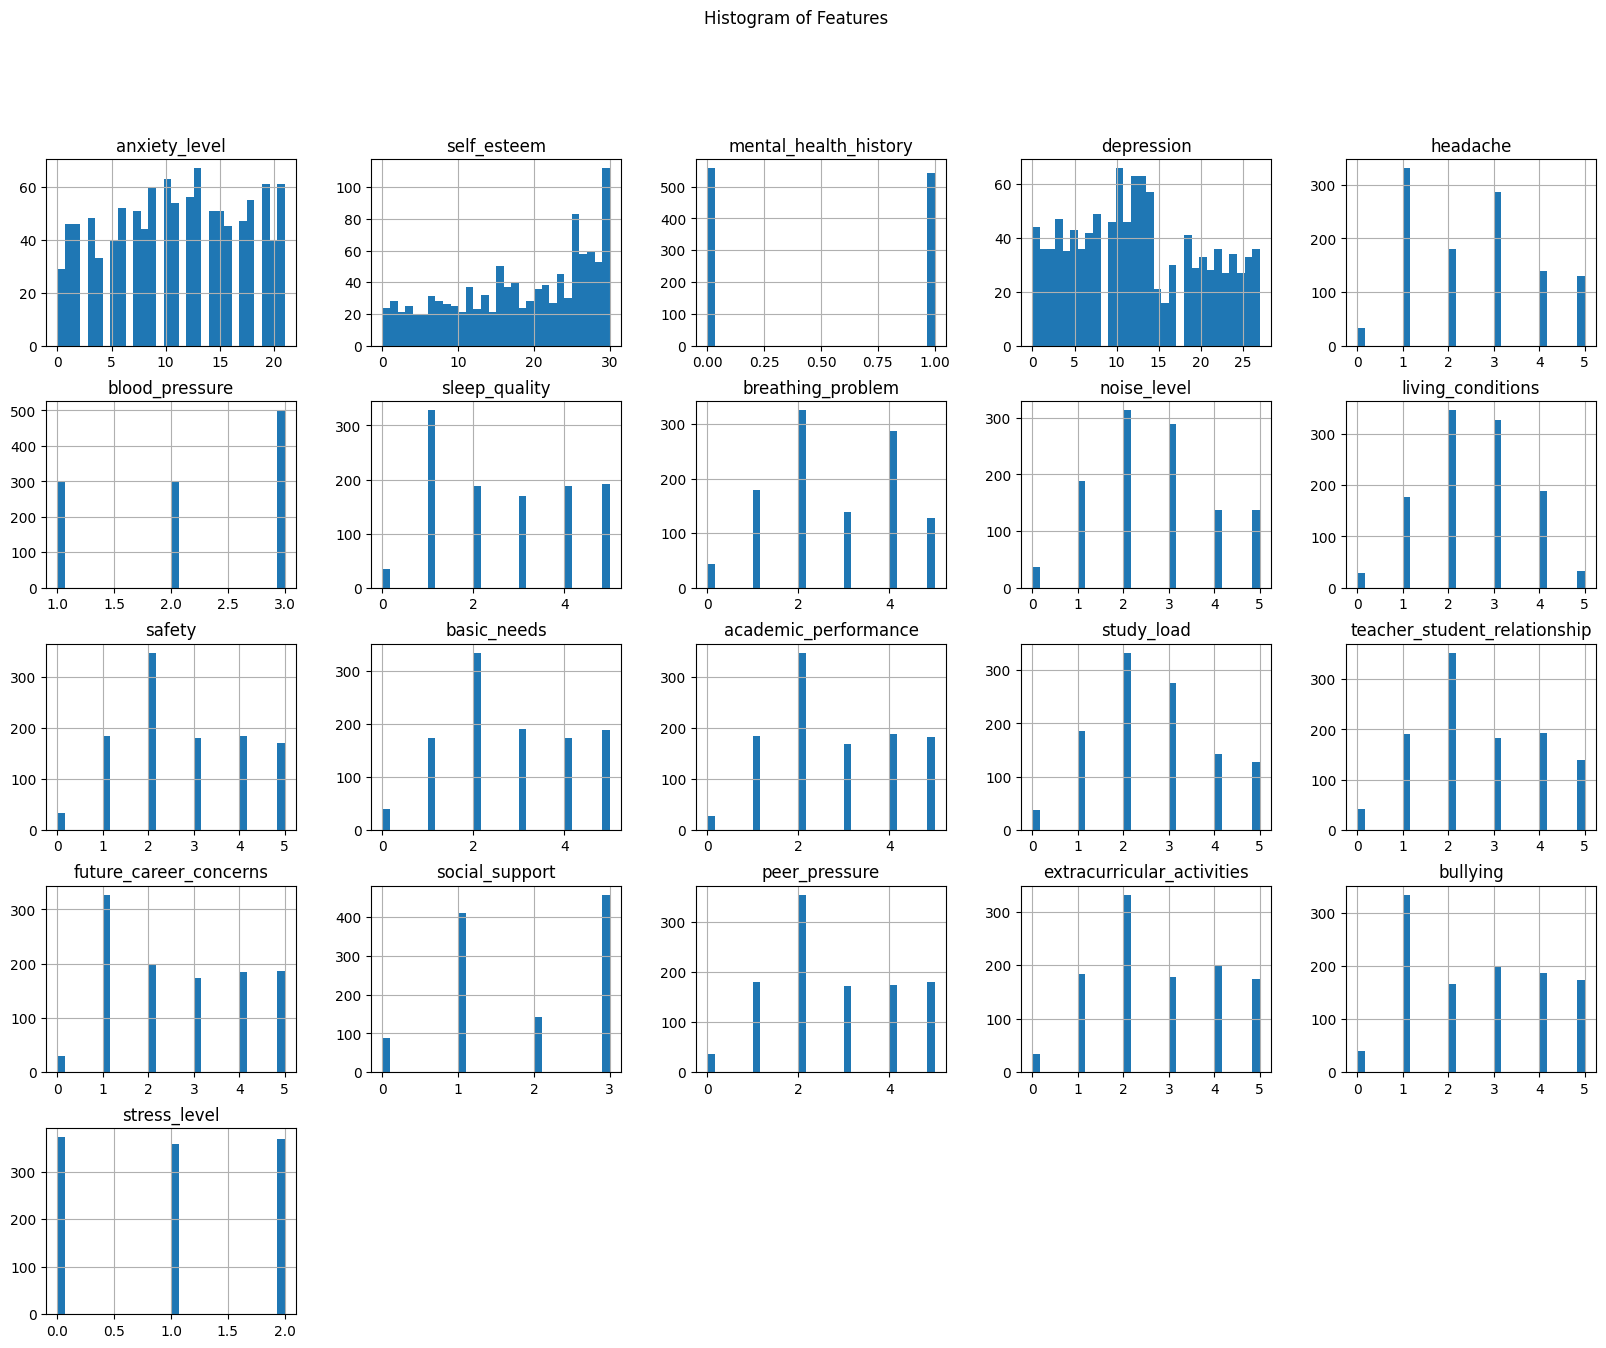

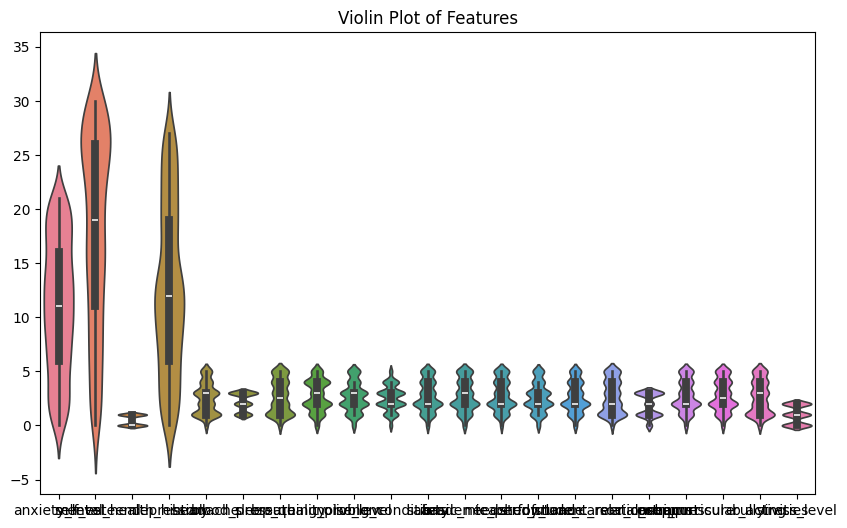

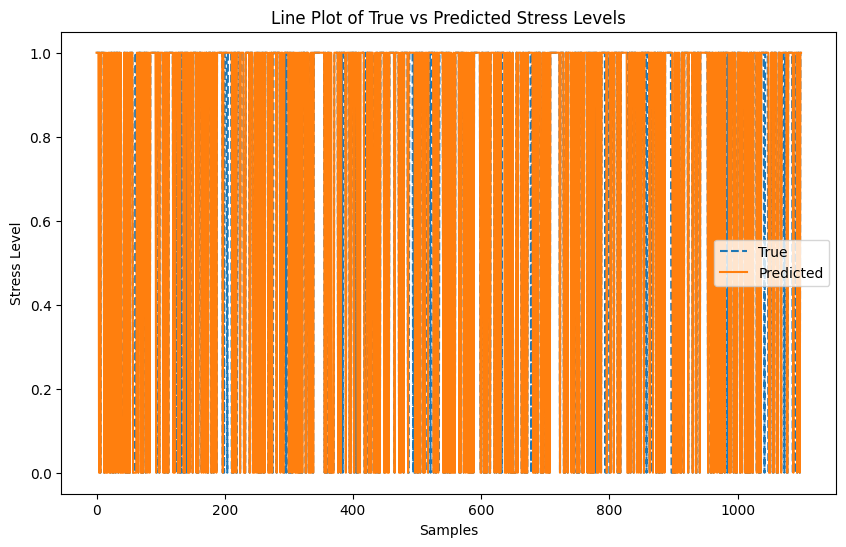

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle

class MetaLearner:
    def __init__(self):
        self.meta_learner = SVC(kernel='linear', probability=True)

    def fit(self, X, y):
        self.meta_learner.fit(X, y)
        return self

    def predict(self, X):
        return self.meta_learner.predict(X)

df = pd.read_csv('')

X = df.drop('stress_level', axis=1)
y = df['stress_level']

X = pd.get_dummies(X)

n_bins = 2  # Define the number of bins
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.values.reshape(-1, 1)).ravel()

initial_size = 0.1  # 10% of the data initially labeled
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y_binned, train_size=initial_size, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

X_train = X_train.values
X_unlabeled = X_unlabeled.values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

n_queries = 10  # Number of queries to label
query_size = 0.1  # Percentage of data to query each iteration

for _ in range(n_queries):
    base_learner = LinearRegression()
    base_learner.fit(X_train_scaled, y_train)

    meta_features_train = base_learner.predict(X_train_scaled).reshape(-1, 1)
    meta_features_unlabeled = base_learner.predict(X_unlabeled_scaled).reshape(-1, 1)

    meta_learner = MetaLearner()
    meta_learner.fit(meta_features_train, y_train)

    probas = meta_learner.meta_learner.predict_proba(meta_features_unlabeled)[:, 1]

    uncertainty = np.abs(probas - 0.5)
    query_indices = np.argsort(uncertainty)[:int(query_size * len(X_unlabeled))]

    X_train = np.vstack([X_train, X_unlabeled[query_indices]])
    y_train = np.hstack([y_train, y_unlabeled[query_indices]])

    X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_indices)

    X_train_scaled = scaler.fit_transform(X_train)
    X_unlabeled_scaled = scaler.transform(X_unlabeled)

base_learner = LinearRegression()
base_learner.fit(X_train_scaled, y_train)

meta_features_train = base_learner.predict(X_train_scaled).reshape(-1, 1)
meta_features_test = base_learner.predict(scaler.transform(X)).reshape(-1, 1)

meta_learner = MetaLearner()
meta_learner.fit(meta_features_train, y_train)

meta_features_test = base_learner.predict(scaler.transform(X)).reshape(-1, 1)
y_pred_binned = meta_learner.predict(meta_features_test)

accuracy = accuracy_score(y_binned, y_pred_binned)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_binned, y_pred_binned)
print(report)

# Pie Chart
unique, counts = np.unique(y_pred_binned, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140)
plt.title('Prediction Distribution')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Features')
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(meta_features_test, y_binned, color='blue', label='True')
plt.scatter(meta_features_test, y_pred_binned, color='red', label='Predicted')
plt.xlabel('Meta Features')
plt.ylabel('Stress Level')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Stress Levels')
plt.show()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Feature Correlations')
plt.show()

# Comparison plot of accuracies
accuracies = {'Base Learner': base_learner.score(scaler.transform(X), y_binned), 'Meta Learner': accuracy}
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies')
plt.show()

# Precision-Recall Curve
probs = meta_learner.meta_learner.predict_proba(meta_features_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_binned, probs)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_binned, probs)
roc_auc = roc_auc_score(y_binned, probs)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.4f})')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_binned, y_pred_binned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, shade=True)
plt.title('KDE Plot of Features')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
df.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histogram of Features')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df)
plt.title('Violin Plot of Features')
plt.show()

# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(y_binned, label='True', linestyle='--')
plt.plot(y_pred_binned, label='Predicted', linestyle='-')
plt.xlabel('Samples')
plt.ylabel('Stress Level')
plt.legend()
plt.title('Line Plot of True vs Predicted Stress Levels')
plt.show()
